##### CVEN 6525 - NONLINEAR ANALYSIS OF FRAMED STRUCTURES
###### FINAL TERM PROJECT - SPRING 2024 - RON BAILIE, UNIVERSITY OF COLORADO BOULDER

<center> Topology Optimization of Minimally Compliant 2D Structural Elements Using the SIMP Method</center><br>
According to Sigmund and Bendsoe, Topology Optimization is a computational approach in structural design that determines the optimal material distribution within a given design domain[1]. Just as in ordinary structural analysis, the design domain is constrained by a set of prescribed boundary conditions and applied external loads, however when a topology optimization method is implemented, the goal of minimizing or maximizing a particular performance index is introduced. 

Topology Optimization methods can vary by type of optimization algorithm, material interpolation scheme, and approach to discretization. These factors can influence the choice of local minima when optimizing a non-convex problem, which can lead an optimization algorithm to more than one potential solution. The existence, uniqueness and stability of a topology optimization solution depends on optimality criteria defined, penlization methods used, and filtering techniques employed. It is important that the optimization components be configured appropriately for the objective criteria, in order to avoid non-intuitive or unstable solutions.

The following is a Python implementation of Ole Sigmund's publication <i>A 99 line topology optimization code written in MATLAB</i>[2]. This Python implementation employs the exact same finite element discretization scheme, objective function setup, mesh-independency filtration technique, and optimality criteria method as demonstrated in Sigmund's MATLAB version. As in the MATLAB version of this code, the objective function for optimization is to minimize compliance and volume for a 2D domain of constant Young's modulus and Poisson's ratio. Subtle differences exist between the MATLAB and Python, mainly indexing and linear algebra techniques.

The following Jupyter notebook separates the Topology Optimization solver into individual code blocks that contain single functions, preceeded by an explanation of the function implementation and description of the function's core components.

The following image depicts three benchmark tests for this Topology Optimization Solver:



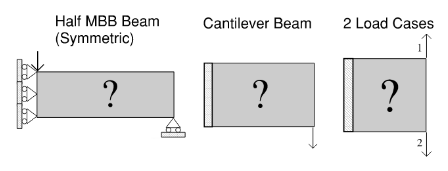

The applied loads and boundary conditions can be adjusted in the FE and topOpt functions to execute the tests shown above. 
 Likewise, the user inputs in __main__ can be tailored to execute these tests. 
 Please refer to the comments in these code blocks.


In [18]:
#Script Header - package imports and formatting
#IPython magic commands
%matplotlib notebook
%matplotlib inline

#package imports
import numpy as np
import base64
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import colors as mcolors
from IPython.display import HTML

np.set_printoptions(precision=4) # limit floating point values to 4 decimal places

#embedding images into Jupyter notebook/encoded into base64
with open("/home/ron/thesis/topopt_simulation_cm2/topOpt benchmark analysis.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
benchmark_images = f'<img src="data:image/png;base64,{encoded_string}"/>'

print('The following image depicts three benchmark tests for this Topology Optimization Solver:')
display(HTML(benchmark_images))
print('The applied loads and boundary conditions can be adjusted in the FE and topOpt functions to execute the tests shown above.','\n'
      ,'Likewise, the user inputs in __main__ can be tailored to execute these tests.','\n'
      ,'Please refer to the comments in these code blocks.')

#### Element Stiffness Matrix
The following function <b>lk</b> generates the local stiffness matrix for a singular 2D finite element, using constant values for Young's modulus and Poisson's ratio. These material properties are fundamental for defining the mechanical behavior of isotropic, linear elastic materials and are required for deriving the constitutive relations used in 2D Hooke's law.<br><br> As this is a 2-Dimensional finite element implementation, the <b>KE</b> matrix occurs as an 8x8 symmetric matrix that reflects the eight degrees of freedom for each 2D element (four nodes, two degrees of freedom per node). Extending this finite element model to a 3-Dimensional implementational would require the addition of z-axis degrees of freedom, which would then need to be carried throughout the other components of the topology optimization solver configuration.<br>

This standard element stiffness matrix is critical to the topology optimization solver, as it determines how effectively the model can predict and optimize structural behavior at the elemental level. This is how the optimization algorithm assesses the impact of material distribution as it iterates towards the design objective.

In [2]:
def lk():
    E = 1.0 # Young's Modulus
    nu = 0.3 # Poisson's Ratio
    k = np.array(
        [
            1 / 2 - nu / 6,
            1 / 8 + nu / 8,
            -1 / 4 - nu / 12,
            -1 / 8 + 3 * nu / 8,
            -1 / 4 + nu / 12,
            -1 / 8 - nu / 8,
            nu / 6,
            1 / 8 - 3 * nu / 8,
        ]
    )
    # local element stiffness matrix
    KE = (
        E
        / (1 - nu**2)
        * np.array(
            [
                [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]],
            ]
        )
    )
    return KE

#### Global Force, Displacement, Stiffness and Constraint setup
Function <b>FE</b> performs a number of tasks for setting up the equilibrium equation (F = KU), including intizialization of global force and displacement vectors, assembly of a global stiffness matrix, and definition of applied loading and boundary conditions at specified degrees of freedom. This function is standard in terms of finite element analysis and is critical for evaulating the mechanical performance of material distributed over the global structural domain during each optimization iteration.<br><br> 
When executed, the <b>FE</b> function uses the design variable <b>x</b>, which represents the material density distribution within the structure. <b>FE</b> adjusts the global stiffness matrix by scaling the elemental stiffness matrices according to the power of the design variable <b>x</b> which is augmented by a penalization factor. This method was developed by M.P. Bendsoe who coined it as the SIMP method, which stands for Solid Isotropic Material with Penalization[3]. The influence of penalization is a key component of topology optimization, as it helps to drive the solution towards a solid or void material distribution solution, and avoid intermediate states whenever possible (represented by any elements in the grayscale, i.e. not explicitly black or white).<br><br>
The <b>FE</b> function is initially configured to solve for the Half-MBB Beam benchmark analysis. The applied load definition, <b>F</b>, along with the fixed degrees of freedom <b>dof_fixed</b> can be changed in order to solve for the cantilever beam and two-load case beam analysis as shown in the image above. See the commented lines within the function to reconfigure for these additional benchmark analyses.

In [3]:
def FE(nelx, nely, x, penal, lk):
    KE = lk() # bring in and intialize local stiffness matrix from lk function
    K = np.zeros(((nelx + 1) * (nely + 1) * 2, (nelx + 1) * (nely + 1) * 2)) # initialize global stiffness matrix
   
    ############################
    # Set number of load cases:
    ############################
    F = np.zeros(((nelx + 1) * (nely + 1) * 2, 1)) # intialize applied force matrix for 1 load cases
    U = np.zeros(((nelx + 1) * (nely + 1) * 2, 1)) # initialize displacement matrix for 1 load cases
    
    # F = np.zeros(((nelx + 1) * (nely + 1) * 2, 2)) # intialize applied force matrix for 2 load cases
    # U = np.zeros(((nelx + 1) * (nely + 1) * 2, 2)) # initialize displacement matrix for 2 load cases


    # global stiffness assembly
    for elx in range(1, nelx + 1): 
        for ely in range(1, nely + 1):
            n1 = (nely + 1) * (elx - 1) + ely  # upper right element node number for Ue
            n2 = (nely + 1) * elx + ely  # extract element disp from global disp
            edof = np.array(
                [
                    2 * n1 - 1,
                    2 * n1,
                    2 * n2 - 1,
                    2 * n2,
                    2 * n2 + 1,
                    2 * n2 + 2,
                    2 * n1 + 1,
                    2 * n1 + 2,
                ]
            )
            K[np.ix_(edof - 1, edof - 1)] += x[ely - 1, elx - 1] ** penal * KE
    
    ############################################
    # Applied Force for each benchmark analysis:
    ############################################
    
    # Applied load for Half-MBB Analysis:
    F[1,0] = -1
    
    # Applied load for 2 Load Case Analysis:
    # F[2 * (nelx + 1) * (nely + 1) - 1, 0] = -1 # load case 1
    # F[2 * (nelx) * (nely + 1) + 1, 1] = 1  # load case 2
    
    # Applied load for Cantilever Analysis:
    # F[2 * (nelx + 1) * (nely + 1) - 1, 0] = -1 
    
    #load placed at middle of beam
    # top_mid_node = (nelx//2) +1
    # F[top_mid_node, 0] = -100
    

    ##################################################
    # Boundary Conditions for each benchmark analysis:
    ##################################################
    
    # Boundary conditions for Half-MBB Analysis:
    dof_fixed = np.union1d(
        np.arange(0, 2 * (nely + 1), 2), np.array([2 * (nelx + 1) * (nely + 1) - 1])
    )
    
    # Boundary conditions for Half-MBB analysis with load placed at middle of beam:
#     dof_fixed = np.union1d(
#     np.arange(0, 2 * (nely + 1), 2), np.array([2 * (nelx + 1) * (nely + 1) - 2 * nely -1])
# )

    # # Boundary conditions for 2 Load Case Analysis & Cantilever Analysis:
    # dof_fixed = np.arange(0, 2 * (nely + 1))


    dofs = np.arange(0, 2 * (nelx + 1) * (nely + 1))
    
    dof_free = np.setdiff1d(dofs, dof_fixed) # filter mask to grab free nodes from node list

    # # SOLVER
    U[dof_free] = np.linalg.solve(K[np.ix_(dof_free, dof_free)], F[dof_free])  # solve for displacement at free nodes
    U[dof_fixed] = 0  # fix geometrically constrained nodes
    
    return U, dof_fixed

#### Mesh-Independency via Sensitivity Analysis

The <b>check</b> function acts as a mesh-independency filter designed to 'smooth out' the design variable field <b>x</b> across the domain of the structure. This smoothing is also referred to as 'sensitivity analysis' and serves to mitigage numerical instabilities such as checkerboarding, artifacting and mesh dependency[4]. The density smoothing is performed by applying a sensitivity filtering technique to each element iteratively. The <b>check</b> function queries neighboring elements within the selected element's user defined radius, <b>rmin</b>, and applies a weighting factor to the neighbor's <b>x</b> value if the neighboring element is determined to be within this influencing radius. The weighting factor calculation is based on the distance from the center of the current element to its neighbors, diminishing with increasing distance until it reaches the boundary defined by <b>rmin</b>.<br>

The sensitivities <b>dc</b> of the design variables are adjusted by multiplying them with their corresponding weights and the values from the neighboring elements' design variables. These weighting sensitivities are then accumulated and subsequently normalized by dividing the product of the current element's design variable and the sum of all applied weights, ultimately adjusting the gradient of the design variable with respect to the objective function (structural compliance). This normalization ensures that the filtered sensitivities are proprtinate and contribute to a uniformly smooth density distribution across the entire domain[4].

The density filtering technique demonstrated here is relatively simple and straight forward, and more importantly appropriate for a 2D minimal compliance optimization consisting of a homogenous, consistently discretized domain. Other methods such as the Heaviside Projection Method, Level Set Method, Topological Derivative Method, or Evolutionary Structural Method (ESO) may need to be employed in circumstances when boundary constraints are sensitive, dramatic changes in topology are possible, material removal or addition is a crucial decision, or when design domains may be excessively large, respectively.[5] The choice of density filtering method will directly influence the validity and quality of the converged optimized solution.

In [4]:
def check(nelx, nely, rmin, x, dc):
    dcn = np.zeros((nely, nelx))  # initialize sensitivity array
    rmin_floor = int(np.floor(rmin)) # filter size

    for i in range(nelx):  # first element in dependency check
        for j in range(nely):  # second element in dependency check
            sum = 0.0
            for k in range(max(i - rmin_floor, 0), min(i + rmin_floor + 1, nelx)):
                for l in range(max(j - rmin_floor, 0), min(j + rmin_floor + 1, nely)):
                    fac = rmin - np.sqrt((i - k) ** 2 + (j - l) ** 2)  # weighting factor with rmin as filter size minus distance between two elements
                    if fac > 0:
                        sum += fac
                        dcn[j, i] += fac * x[l, k] * dc[l, k]
            if sum > 0:
                dcn[j, i] /= x[j, i] * sum
    return dcn

#### Optimality Criteria via the bi-sectioning algorithm
The <b>OC</b> (Optimality Criteria) function is a key component in finding a material distribution that minimizes structural compliance for the targeted material volume constraint. This particular approach uses a bi-sectioning algorithm, which is a fundamental numerical technique that is effective for the given homogenous design domain and a single objective function. The bi-sectioning algorithm falls short as optimization scenarios become more complex, for example if multiple constraints are introduced (e.g. displacement limits or specific material behavior), or if non-linear applied loads or material properties are within the problem landscape[3]. In these example scenarios, the bi-sectioning algorithm will likely struggle to converge to a solution efficiently, or may fail to find a satisfactory solution. This is in large part because the bi-sectioning algorithm simply 'bi-sects' an upper and lower initial bound in a linear fashion to calculate a midpoint, which serves as a Lagrange multiplier used to influence the design variable (density in this case). A more complex analysis would call for a  more robust optimality algorithm, such as the Method of Moving Asymptotes (MMA) or Sequential Quadratic Programming, both of which allow for more advanced constraint interactions at the cost of complexity and computing power[2].<br><br>

The bisection method linearly narrows down the search interval for the Lagrange multiplier, which is then used to adjust the design variable <b>x</b> based on the sensitivity gradient of the objective function <b>dc</b>, which reflects how changes in <b>x</b> affect the objective function. The design variable then updates to <b>xnew</b>, based on the gradient, which is then compared to the prescribed volume constraint. If the total volume of <b>xnew</b> is greater than the user defined volume, then the lower bound <b>l1</b> is set to <b>lmid</b>, which narrows the bi-sectioning interval. If the volume of <b>xnew</b> is less than the user defined volume, then the upper bound <b>l2</b> is updated to <b>lmid</b>.<br><br>

This approach is the main driver towards re-distribution of material and achieving a converged solution. By iteratively adjusting the design variables based on Lagrange multipliers and the gradient of the objective function, the <b>OC</b> function guides material re-distribution towards optimal structural performance.

In [5]:
def OC(nelx: int, nely: int, x: np.array, volfrac: float, dc: np.array):
    l1 = 0  # lower bi-sectioning bound
    l2 = 1e5  # upper bi-sectioning bound
    move = 0.2  # sectioning increment (eta)
    iteration_data = [] # initialize for bi-sectioning plot
    
    while (l2 - l1) > 1e-4: #note that 1e-4 represents the minimum bound for density, to prevent any possible singularity
        lmid = 0.5 * (l2 + l1)  # middle bi-sectioning value (lagrange multiplier)
        xnew = np.maximum(0.001,np.maximum(x - move, np.minimum(1.0, np.minimum(x + move, x * np.sqrt(-dc / lmid)))),) # sensitivity-adjusted design value
        current_volume = np.sum(xnew) / (nelx * nely) # for bi-sectioning plot
        iteration_data.append((lmid, current_volume)) # store values for bi-sectioning plot
        
        if np.sum(xnew) - volfrac * nelx * nely > 0:
            l1 = lmid
        else:
            l2 = lmid
    return xnew, iteration_data

#### Animation plot
This function takes the stored density values for each element for each iteration and stores them in individual image frames. The frames are then passed to matplotlib's FuncAnimation function which animates the images in series, generating a dynamic plot that helps illustrate the iterative changes occuring in the design throughout the optimization process.

In [6]:
def make_animation(nelx, nely, x_hist):
    x_hist = x_hist[::2] # stored density values
    fig, ax = plt.subplots()
    im = ax.imshow(-x_hist[0], cmap="gray", animated=True)

    def update_frame(frame):
        x = -x_hist[frame]
        im.set_array(x)
        return (im,)

    anim = animation.FuncAnimation(
        fig,
        update_frame,
        frames=len(x_hist),
        blit=True,
    )
    plt.close(fig)
    return anim

### Convergence Plot
This function visualizes the convergence of the objective function by plotting stored <b>c</b> values against the number of iterations performed. By visualizing the convergence, we can compare relative speed and efficiency between different topology criteria, which is important for evaluating algorithm performance.

In [7]:
def convergencePlot(c_hist):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(c_hist) + 1), c_hist, marker="o", linestyle="-", color="b")
    plt.title("Objective Function Convergence")
    plt.xlabel("Iteration Number")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

#### Main Topology Optimization Function

The <b>topOpt</b> function coordinates auxillary functions to iteratively update the material distribution inside the design domain. These iterations continue until the design objective (minimal structural compliance) is achieved for the specified fractional volume. Initially, the design variable <b>x</b> is uniformly set to target volume fraction. Then, <b>x</b> is iteratively udated using the <b>OC</b> function, based on sensitivity analysis that determines the impact of design changes on structural compliance. Mesh-independence filtering is applied by the <b>check</b> function to ensure numerical stability. The <b>topOpt</b> function continuously computes displacements using the <b>FE</b> function to maintain equilibrium. Material is distributed to areas of the design domain with the highest amounts of strain energy to achieve this.<br><br>
This iterative loop continues until the change in design variable <b>x</b> falls below the specified threshold (1% as defined in the <b>topOpt</b> function). A solution is considered to be converged once the observed change between iteration is 1%. Once converged, the stored x values <b>x_hist</b> are ported to the animation function where the iterations are stitched together in a frame by frame animation.

In [8]:
def topOpt(nelx, nely, volfrac, penal, rmin, n_iter: int):
    x_hist = []  # initialize x for animation
    c_hist = []  # initialize c for convergence plot
    x = np.ones((nely, nelx)) * volfrac  # initialize matrix populated by volfrac,
    loop = 0  # intialize iterations for optimization
    change = 1.0  # updates iter

    while (change > 0.01):  # continues as change > 0.01, at which point convergence is observed
        loop += 1  # iteration counter
        xold = np.copy(x)  # store current x

        if loop > n_iter: # breaks function out of loop at set iteration number in case of divergence
            break

        # FE Analysis
        U, dof_fixed = FE(nelx, nely, x, penal, lk)  # displacement vector U

        KE = lk()
        c = 0.0  # initialize objective function value (compliance) as zero float type
        dc = np.zeros((nely, nelx))  # initialize sensitivity of objection function to 0
        for ely in range(1, nely + 1):  # nested for loop over element y component
            for elx in range(1, nelx + 1):  # nested foor loop over element x component
                
                n1 = (nely + 1) * (elx - 1) + ely # upper left element node for Ue
                n2 = (nely + 1) * (elx) + ely # upper right element node for Ue
                Ue_indices = [
                    2 * n1 - 2,
                    2 * n1 - 1,
                    2 * n2 - 2,
                    2 * n2 - 1,
                    2 * n2,
                    2 * n2 + 1,
                    2 * n1,
                    2 * n1 + 1,]
                
                
                ##############################################################################
                # For Half-MBB Benchmark Analysis and Cantilever Analysis (single load cases):
                ##############################################################################
                Ue = U[Ue_indices]  # Extract element displacement vector
                f_int = np.dot(Ue.T, np.dot(KE, Ue)) # internal force vector
                f_int = f_int.item() # Convert to scalar
                c += (x[ely - 1, elx - 1] ** penal * f_int)  # add elemental contribution to objective function
                dc[ely - 1, elx - 1] = (-penal * x[ely - 1, elx - 1] ** (penal - 1) * f_int)  # sensitivity calculation of objective function

                ##################################################################
                # For 2 Load Case Benchmark Analysis (Loop over each loade case):
                ##################################################################
                # for i in range(2):  # U has two columns, one for each load case
                #     Ue = U[Ue_indices, i]  # Extract the displacement vector for the element for load case i
                #     f_int = np.dot(Ue.T, np.dot(KE, Ue))
                #     c += x[ely - 1, elx - 1]**penal * f_int
                #     dc[ely - 1, elx - 1] -= penal * x[ely - 1, elx - 1]**(penal - 1) * f_int


        c_hist.append(c.item()) # stores c value for convergence plot
        dc = check(nelx, nely, rmin, x, dc)  # filter sensitivies with check function
        x, iteration_data = OC(nelx, nely, x, volfrac, dc)  # update design variable x based on OC function
        change = np.max(np.abs(x - xold))  # calclulate max value to check convergence
        
        print(f"Iteration: {loop}, Objective: {c.item():.4f}, Volume: {np.mean(x):.4f}, Change: {change:.4f}")

        x_hist.append(x.copy()) # stores x for animation
    return (nelx, nely, x_hist, c_hist, dof_fixed, iteration_data)

#### Parameter Definition and Main Function Execution
The element domain size, defined fractional volume, penalization factor, and filter radius is defined. These parameters are broken out and labeled for specific benchmark analysis problems.<br><br>
The main topology optimization function is executed here. Please note the function can take upwards of 3 minutes to complete depending on the size of the design domain.

In [9]:
#Half-MBB Benchmark Design Parameters
nelx = 60 # number elements in x axis
nely = 30 # number elements in y axis
volfrac = 0.5  # fractional volume to remain after optimization
penal = 3.0  # penalization factor for intermediate density values
rmin = 1.5  # prevents checkerboarding and mesh dependancies (filter size)

# #Cantilever Benchmark Design Parameters
# nelx = 32 # number elements in x axis
# nely = 20 # number elements in y axis
# volfrac = 0.4  # fractional volume to remain after optimization
# penal = 3.0  # penalization factor for intermediate density values
# rmin = 1.2  # prevents checkerboarding and mesh dependancies (filter size)

# #2 Load Case Benchmark Design Parameters
# nelx = 30 # number elements in x axis
# nely = 30 # number elements in y axis
# volfrac = 0.4  # fractional volume to remain after optimization
# penal = 3.0  # penalization factor for intermediate density values
# rmin = 1.2  # prevents checkerboarding and mesh dependancies (filter size)

# Run optimization
nelx, nely, x_hist, c_hist, dof_fixed, iteration_data = topOpt(nelx, nely, volfrac, penal, rmin, n_iter=400)

Iteration: 1, Objective: 391.9097, Volume: 0.5000, Change: 0.2000
Iteration: 2, Objective: 236.9787, Volume: 0.5000, Change: 0.2000
Iteration: 3, Objective: 173.3894, Volume: 0.5000, Change: 0.2000
Iteration: 4, Objective: 144.8332, Volume: 0.5000, Change: 0.2000
Iteration: 5, Objective: 133.0525, Volume: 0.5000, Change: 0.2000
Iteration: 6, Objective: 124.3604, Volume: 0.5000, Change: 0.2000
Iteration: 7, Objective: 118.4086, Volume: 0.5000, Change: 0.2000
Iteration: 8, Objective: 113.8797, Volume: 0.5000, Change: 0.1797
Iteration: 9, Objective: 110.2793, Volume: 0.5000, Change: 0.1826
Iteration: 10, Objective: 106.8551, Volume: 0.5000, Change: 0.2000
Iteration: 11, Objective: 103.2474, Volume: 0.5000, Change: 0.1674
Iteration: 12, Objective: 99.9583, Volume: 0.5000, Change: 0.1510
Iteration: 13, Objective: 97.3007, Volume: 0.5000, Change: 0.1852
Iteration: 14, Objective: 94.9032, Volume: 0.5000, Change: 0.2000
Iteration: 15, Objective: 92.6671, Volume: 0.5000, Change: 0.2000
Iteratio

#### Bi-Sectioning Algorithm Plot
This plot visualizes how much of an impact the penalization factor is making on the fractional volume of the design domain. Initially, there are significant changes in volume reduction with a relatively small value for the lagrange multiplier. As the number of iterations begins to build up, and the topology begins to converge towards a definite solution, the penalization factor.

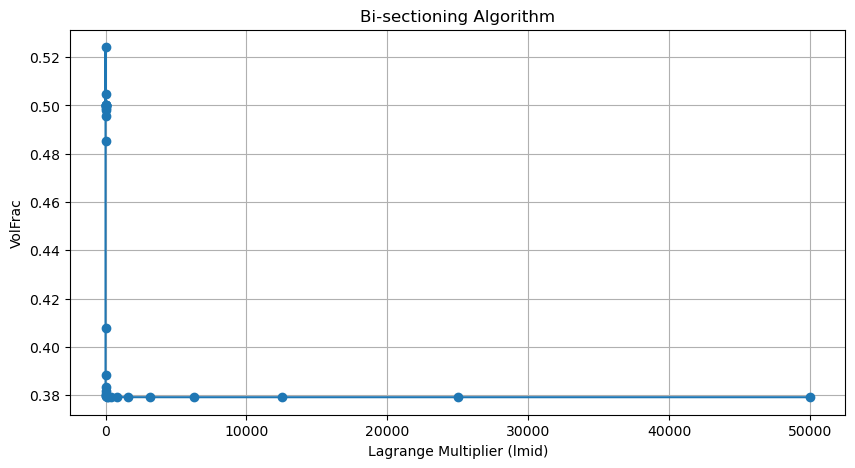

In [10]:
lmids, volumes = zip(*iteration_data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(lmids, volumes, marker='o')
plt.title('Bi-sectioning Algorithm')
plt.xlabel('Lagrange Multiplier (lmid)')
plt.ylabel('VolFrac')
plt.grid(True)
plt.show()

#### Objective Function Convergence Plot

This plot demonstrates the rate at which the objective function converges to a solution with minimal change between iterations. As with the plot above visualizing the impact of the lagrange multiplier, we see that there are large initial changes in fractional volume during the initial iterations of the optimization algorithm. This can also be observed in the first few seconds of the animation below, as density begins to form major structural members within the design domain, and large swaths of void space begin to collect. <br><br> As the algorithm continues to work towards convergence, smaller structural members begin to dissapear, and their volume is collected into nearby, more dominant members. The Objective Convergence Plot, Bi-Sectioning Algorithm Plot, and Animation all provide a visualization of the SIMP method.

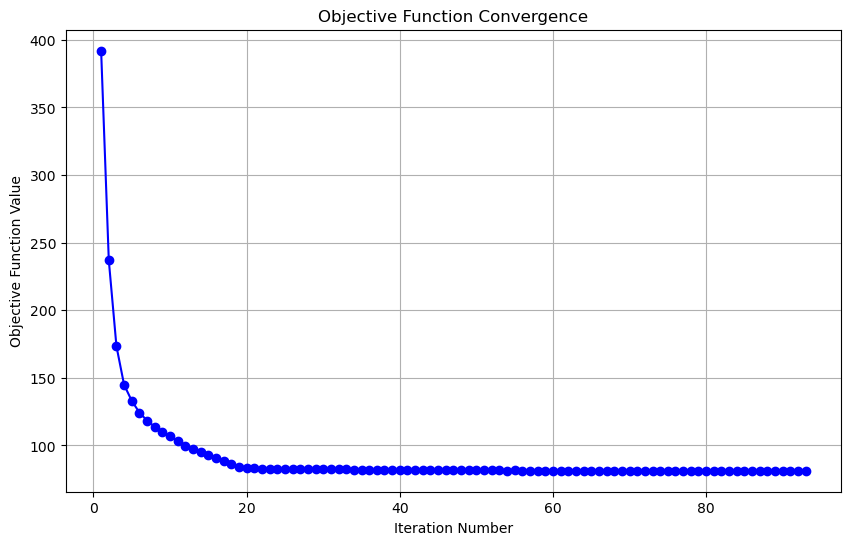

In [11]:
# Display convergence plot
convergencePlot(c_hist)

#### Visualization of Boundary Conditions and Applied Loads

The following plot consists of all elements of the design domain shown in gray. The elements possessing geometrically constrained degrees of freedom (i.e. prescribed boundary conditions) are represented in red.<br><br>
*note:* I was in the process of visualizing the applied node in green, but it seems that there are bugs in the code, and this feature needs refinement.<br>

This is a quick way to verify that the boundary conditions and prescribed loads have been applied correctly in the FE function, based on the extends of the design domain that have been user defined in the __main__ function.

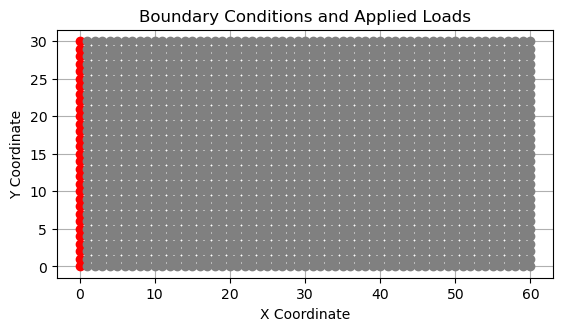

In [12]:
def plot_nodes(nelx, nely, dof_fixed):
    
    fig, ax = plt.subplots()
    for i in range(nelx + 1):
        for j in range(nely + 1):
            node_index_x = 2 * (i * (nelx + 1) + j)     # DOF index for x-direction
            node_index_y = node_index_x + 1             # DOF index for y-direction

            if node_index_x in dof_fixed or node_index_y in dof_fixed:
                color = 'red'  # Fixed node
            # elif node_index_y == load_dof:
            #     print("Green node at: ", i, j)
            #     color = 'green' # Applied load
            else:
                color = 'gray'  # Free node

            ax.plot(i, j, 'o', color=color)

    ax.set_aspect('equal', adjustable='box')
    plt.title('Boundary Conditions and Applied Loads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

plot_nodes(nelx, nely, dof_fixed)

#### Animation of Optimized Design

The animation shows the solution that we consider to be converged. The rate of convergence visualized here aligns with that observed in the bi-sectioning and objective function plots.

The optimization starts off as a gray and amorphous figure, and quickly we see black structural members (representing a density value of 1) emerge and settle into positions where structural stiffness needs to be maximized. The final converged solution represents the structural configuration with minimal compliance for the prescribed fractional volume. Material is prioritized to areas of high strain energy in order to arrive at a solution that satisfies both equilibrium and minimum compliance.


In [13]:
# Display animation
ani = make_animation(nelx, nely, x_hist)
HTML(ani.to_html5_video())

#### Conclusions

This demonstration of topology optimization highlights the inherently non-linear behavior of material distribution under prescribed design constraints, naimed at minimizing structural compliance and efficient use of material. The non-linear aspects are exhibited through the SIMP approach, where material stiffness is permutated by a power-law function of the material density, which introduces a fundmaental non-linearity to the optimization problem. In addition, gradient based sensitivity analysis is employed, and material is re-distributed with priority given to domain regions experiencing large amounts of strain energy. The interaction between defined material properties, constitutive relations, and structural response under load embody non-linear behavior at the center of the topology optimization process. Sigumund's 99 line MATLAB implementation is a great introduction to this method and has provided me with a fundamental understanding of how optimization algorithms can be implemented into design problems using solid mechanics, finite elements and computational techniques.

#### REFERENCES
[1]Sigmund, O. 2001: A 99 line topology optimization code written in MATLAB. <i>Structural Multidisciplinary Optimization</i> 21, 120-127<br><br>
[2]Bendsoe, Martin P. and O. Sigmund. <i>Topology Optimization: Theory, Methods and Applications.</i> Springer, 2003<br><br>
[3]Bendsoe, M.P. 1989: Optimal shape design as a material distribution problem. <i>Struct. Optim.</i> 1, 193-202<br><br>
[4]Sigmund, O.; Petersson, J. 1998: Numerical instabilities in topology optimization: a survey on procedures dealing with checkerboards, mesh-dependencies and local minima. <i>Struct. Optim.</i> 16, 68-75<br><br>
[5]Li, Q.; Steven, G.P.; Xie, Y.M. 1999: On equvalence between stress criterion and stiffness criterion in evolutionary structural optimization. <i>Struct. Optim.</i> 18, 67-73<br><br>


